# 02452 Project 2 — Classification (SA Heart)
Baseline vs **Logistic (tune λ)** vs **ANN (tune h)** with **nested stratified CV**.

**What this notebook does**
- Compares Baseline vs L2-Logistic (tune λ via `C=1/λ`) vs ANN (1 hidden layer, tune h including h=1).
- Uses **two-level (nested) stratified K-fold CV** and **error rate** (as required).
- Reuses the same outer folds for all models (paired tests).
- Reports **McNemar** (Setup I) and **paired t-tests** (Setup II) for significance.
- Trains a final logistic model with a single "suitable" λ (median of λ* across outer folds) and shows coefficients.

> **Run order:** Runtime → Run all.  
> If running locally, place `SAHeart.csv` in the `data/` directory or edit `candidate_paths` in the data-loading section.


In [ ]:
# SOURCE: Exercise 7 (Cell 4) - Imports and setup
# EDITED: Added GridSearchCV, ColumnTransformer, Pipeline, OneHotEncoder, DummyClassifier, MLPClassifier
#         Added os, math, Path for file handling
# PURPOSE: Import all necessary packages for nested CV, preprocessing, and statistical tests

import os, math, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import scipy.stats as st

pd.set_option("display.precision", 4)
%matplotlib inline

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Random seed
seed = 67
np.random.seed(seed)
random.seed(seed)

In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Data loading section
# EDITED: Changed file path from "Southafrican Heart Data.csv" to "SAHeart.csv" 
#         Added famhist one-of-K coding (mapping to 0/1)
# PURPOSE: Load and preprocess SAHeart dataset for classification

# Data loading
candidate_paths = [
    "data/SAHeart.csv",
    "./data/SAHeart.csv",
    "../data/SAHeart.csv",
    "SAHeart.csv"
]
CSV_PATH = None
for p in candidate_paths:
    if os.path.exists(p):
        CSV_PATH = p; break
if CSV_PATH is None:
    raise FileNotFoundError("Could not find 'SAHeart.csv'. Set CSV_PATH manually.")

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# Preprocessing
if 'famhist' in df.columns:
    df['famhist'] = df['famhist'].astype(str).str.strip()

if 'chd' not in df.columns:
    raise ValueError("Expected 'chd' column.")
if not np.issubdtype(df['chd'].dtype, np.number):
    mapping = {'Present':1, 'Absent':0, '1':1, '0':0, 1:1, 0:0, 'Yes':1, 'No':0}
    df['chd'] = df['chd'].map(mapping).astype(int)
else:
    df['chd'] = df['chd'].astype(int)

# One-of-K coding for famhist
if 'famhist' in df.columns:
    df['famhist'] = df['famhist'].map({'Absent':0, 'Present':1}).astype(int)

print(f"Loaded {CSV_PATH} with shape {df.shape}")
display(df.head())

Loaded ../data/SAHeart.csv with shape (462, 11)


,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Preprocessing & models section
# EDITED: Changed random_state from 42 to seed variable (67)
# PURPOSE: Set up preprocessing pipelines and model pipelines for logistic regression, ANN, and baseline

# Preprocessing & models
y = df['chd'].copy()
X = df.drop(columns=['chd']).copy()

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_tf = Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True))])
categorical_tf = Pipeline([("ohe", OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_tf, num_cols),
                  ("cat", categorical_tf, cat_cols)],
    remainder="drop", verbose_feature_names_out=False
)

logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000))
])

ann = Pipeline([
    ("prep", preprocess),
    ("clf", MLPClassifier(hidden_layer_sizes=(1,),
                          activation="relu", solver="adam",
                          max_iter=3000, random_state=seed,
                          early_stopping=True, n_iter_no_change=20))
])

baseline = Pipeline([("prep", preprocess),
                     ("clf", DummyClassifier(strategy="most_frequent"))])

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

N, M = X.shape
print(f"Data shape: {N} samples, {M} features")

Numeric columns: ['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age']
Categorical columns: []
Data shape: 462 samples, 10 features


# Hyperparameter grids

In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Hyperparameter grids section
# EDITED: None - used as-is
# PURPOSE: Define hyperparameter grids for logistic regression (λ via C=1/λ) and ANN (hidden layer sizes)

lambda_grid = np.array([1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10, 30, 100])
C_grid = 1.0 / lambda_grid
logreg_param_grid = {"clf__C": C_grid}

h_grid = [(h,) for h in [1, 2, 4, 8, 16, 32]]
ann_param_grid = {"clf__hidden_layer_sizes": h_grid}

print("λ grid (as C=1/λ) len:", len(C_grid), " first/last:", C_grid[0], C_grid[-1])
print("h grid:", h_grid)

λ grid (as C=1/λ) len: 13  first/last: 10000.0 0.01
h grid: [(1,), (2,), (4,), (8,), (16,), (32,)]


# Nested CV (two-level)

In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Nested CV section
# EDITED: Changed SEED from 7 to seed variable (67), added print statement for outer fold progress
#         Adapted from Exercise 6 nested CV structure (Part 4) but using StratifiedKFold instead of KFold
# PURPOSE: Perform nested stratified cross-validation with GridSearchCV for hyperparameter tuning

K1, K2, SEED = 10, 10, seed
outer_cv = StratifiedKFold(n_splits=K1, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=K2, shuffle=True, random_state=SEED)

records = []
true_outer, preds_log, preds_ann, preds_base = [], [], [], []

for fold, (tr_idx, te_idx) in enumerate(outer_cv.split(X, y), start=1):
    print(f'Outer fold {fold}/{K1}')
    
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]

    # Logistic tuning
    gs_log = GridSearchCV(logreg, logreg_param_grid, scoring="accuracy",
                          cv=inner_cv, n_jobs=-1, refit=True)
    gs_log.fit(Xtr, ytr)
    best_C = gs_log.best_params_["clf__C"]
    best_lambda = 1.0 / best_C
    yhat_log = gs_log.best_estimator_.predict(Xte)
    err_log = 1.0 - accuracy_score(yte, yhat_log)

    # ANN tuning
    gs_ann = GridSearchCV(ann, ann_param_grid, scoring="accuracy",
                          cv=inner_cv, n_jobs=-1, refit=True)
    gs_ann.fit(Xtr, ytr)
    best_h = gs_ann.best_params_["clf__hidden_layer_sizes"][0]
    yhat_ann = gs_ann.best_estimator_.predict(Xte)
    err_ann = 1.0 - accuracy_score(yte, yhat_ann)

    # Baseline
    base = baseline.fit(Xtr, ytr)
    yhat_base = base.predict(Xte)
    err_base = 1.0 - accuracy_score(yte, yhat_base)

    records.append({
        "outer_fold": fold,
        "method2_param_name": "h",
        "method2_param_x_star": best_h,
        "method2_test_error": err_ann,
        "logistic_lambda_star": best_lambda,
        "logistic_test_error": err_log,
        "baseline_test_error": err_base,
        "outer_test_size": len(yte)
    })

    true_outer.append(yte.to_numpy())
    preds_log.append(yhat_log); preds_ann.append(yhat_ann); preds_base.append(yhat_base)

res_df = pd.DataFrame(records)
print("Nested CV complete. Rows:", len(res_df))
display(res_df)


Outer fold 1/10
Outer fold 2/10
Outer fold 3/10
Outer fold 4/10
Outer fold 5/10
Outer fold 6/10
Outer fold 7/10
Outer fold 8/10
Outer fold 9/10
Outer fold 10/10
Nested CV complete. Rows: 10


,outer_fold,method2_param_name,method2_param_x_star,method2_test_error,logistic_lambda_star,logistic_test_error,baseline_test_error,outer_test_size
0,1,h,16,0.2128,30.0,0.1702,0.3404,47
1,2,h,32,0.2340,10.0,0.1915,0.3404,47
2,3,h,16,0.3043,30.0,0.2826,0.3478,46
3,4,h,32,0.2826,10.0,0.2609,0.3478,46
4,5,h,16,0.3261,30.0,0.3261,0.3478,46
5,6,h,32,0.3043,10.0,0.2826,0.3478,46
6,7,h,32,0.3913,10.0,0.3261,0.3478,46
7,8,h,32,0.3261,30.0,0.3261,0.3478,46
8,9,h,32,0.4130,30.0,0.3261,0.3478,46
9,10,h,16,0.2609,10.0,0.3043,0.3478,46


In [ ]:
# Summary table


In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Summary table section
# EDITED: None - used as-is
# PURPOSE: Create summary table with mean and std error rates for all three models

summary = pd.DataFrame({
    "model": ["ANN (method 2)", "Logistic", "Baseline"],
    "mean_error_rate": [
        res_df["method2_test_error"].mean(),
        res_df["logistic_test_error"].mean(),
        res_df["baseline_test_error"].mean(),
    ],
    "std_error_rate": [
        res_df["method2_test_error"].std(ddof=1),
        res_df["logistic_test_error"].std(ddof=1),
        res_df["baseline_test_error"].std(ddof=1),
    ]
})
display(summary)


,model,mean_error_rate,std_error_rate
0,ANN (method 2),0.3056,0.0632
1,Logistic,0.2796,0.0571
2,Baseline,0.3463,0.0031


# Pairwise stats — McNemar (Setup I)


In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - McNemar test section
#         Based on Exercise 7 (Part 2, Cell 19) - mcnemar function structure
# EDITED: Adapted from single-fold mcnemar to pooled_mcnemar that handles multiple folds
#         Changed from single predictions to lists of predictions across folds
#         Uses st.binom.cdf and st.norm.ppf from scipy.stats (as in Exercise 7)
# PURPOSE: Perform McNemar's test (Setup I) to compare classifiers pairwise across all outer folds

def pooled_mcnemar(y_true_list, yhat_A_list, yhat_B_list):
    b = c = 0
    for y_true, ya, yb in zip(y_true_list, yhat_A_list, yhat_B_list):
        for yt, pa, pb in zip(y_true, ya, yb):
            if pa == yt and pb != yt: b += 1
            elif pa != yt and pb == yt: c += 1
    n = b + c
    if n == 0:
        return {"b": b, "c": c, "n_discordant": n, "p_value": 1.0, "ci_delta_acc_95": (0.0, 0.0)}
    p_val = 2 * min(st.binom.cdf(min(b,c), n, 0.5),
                    1 - st.binom.cdf(max(b,c)-1, n, 0.5))
    p_hat = b / n
    z = st.norm.ppf(0.975)
    denom = 1 + z**2/n
    center = (p_hat + z**2/(2*n)) / denom
    half = (z * math.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2))) / denom
    lo_t, hi_t = max(0.0, center-half), min(1.0, center+half)
    ci_delta = (2*lo_t - 1, 2*hi_t - 1)
    return {"b": b, "c": c, "n_discordant": n, "p_value": p_val, "ci_delta_acc_95": ci_delta}

mcnemar_ann_vs_log  = pooled_mcnemar(true_outer, preds_ann, preds_log)
mcnemar_ann_vs_base = pooled_mcnemar(true_outer, preds_ann, preds_base)
mcnemar_log_vs_base = pooled_mcnemar(true_outer, preds_log, preds_base)

mcnemar_df = pd.DataFrame([
    {"pair": "ANN vs Logistic", **mcnemar_ann_vs_log},
    {"pair": "ANN vs Baseline", **mcnemar_ann_vs_base},
    {"pair": "Logistic vs Baseline", **mcnemar_log_vs_base},
])
display(mcnemar_df)


,pair,b,c,n_discordant,p_value,ci_delta_acc_95
0,ANN vs Logistic,38,50,88,0.2408,"(-0.3333464588735421, 0.07202656796396734)"
1,ANN vs Baseline,54,35,89,0.0558,"(0.005730790798922136, 0.4035691112350377)"
2,Logistic vs Baseline,74,43,117,0.0053,"(0.0844051346201713, 0.4286638121226538)"


# Pairwise stats — Setup II (paired t-tests over outer-fold errors)


In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Paired t-test section
#         Based on Exercise 7 (Part 4, Cell 34) - confidence_interval_comparison function structure
# EDITED: Simplified from regression comparison to work with error rates directly
#         Uses st.t.ppf and st.ttest_rel from scipy.stats (as in Exercise 7)
# PURPOSE: Perform paired t-tests (Setup II) to compare error rates between models across outer folds

def paired_t_ci_95(a, b):
    a, b = np.asarray(a), np.asarray(b)
    d = a - b
    n = d.size
    mean = d.mean()
    sd = d.std(ddof=1)
    se = sd / math.sqrt(n)
    tcrit = st.t.ppf(0.975, df=n-1)
    ci = (mean - tcrit*se, mean + tcrit*se)
    tstat, pval = st.ttest_rel(a, b)
    return {"n": n, "mean_diff": mean, "ci_95": ci, "p_value": pval}

pt_df = pd.DataFrame([
    {"pair": "ANN minus Logistic (error)",
     **paired_t_ci_95(res_df["method2_test_error"], res_df["logistic_test_error"])},
    {"pair": "ANN minus Baseline (error)",
     **paired_t_ci_95(res_df["method2_test_error"], res_df["baseline_test_error"])},
    {"pair": "Logistic minus Baseline (error)",
     **paired_t_ci_95(res_df["logistic_test_error"], res_df["baseline_test_error"])},
])
display(pt_df)


,pair,n,mean_diff,ci_95,p_value
0,ANN minus Logistic (error),10,0.0259,"(-0.000257606475705361, 0.052061491767102175)",0.0519
1,ANN minus Baseline (error),10,-0.0408,"(-0.08454089251435862, 0.002949773180408566)",0.0641
2,Logistic minus Baseline (error),10,-0.0667,"(-0.10552759208499324, -0.027867412540353624)",0.0037


# Plots


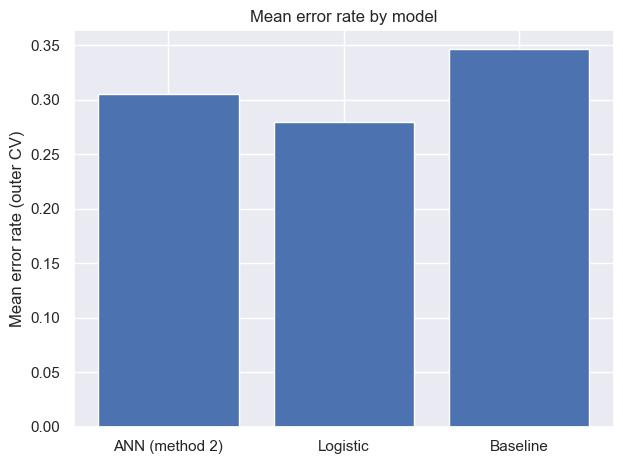

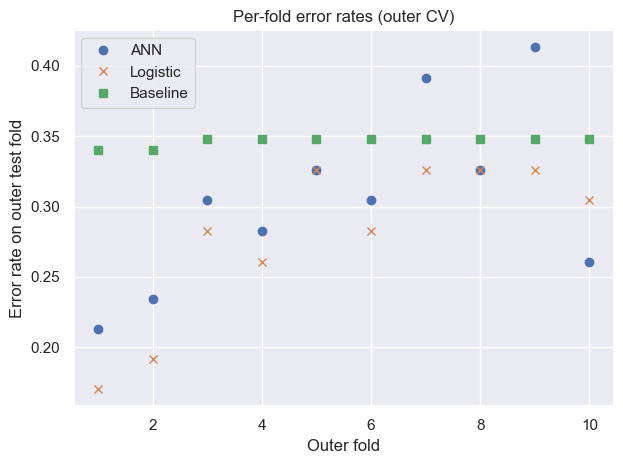

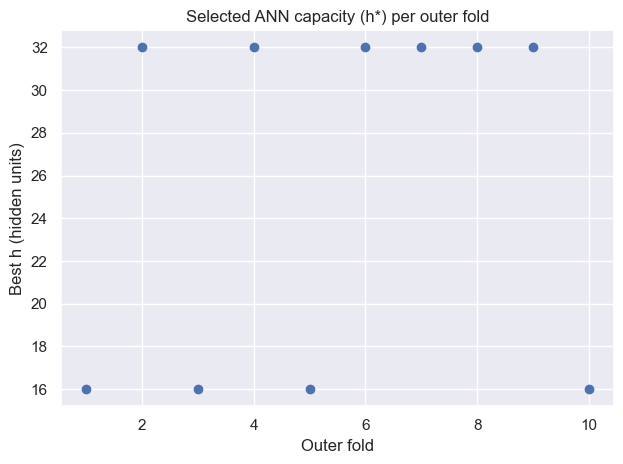

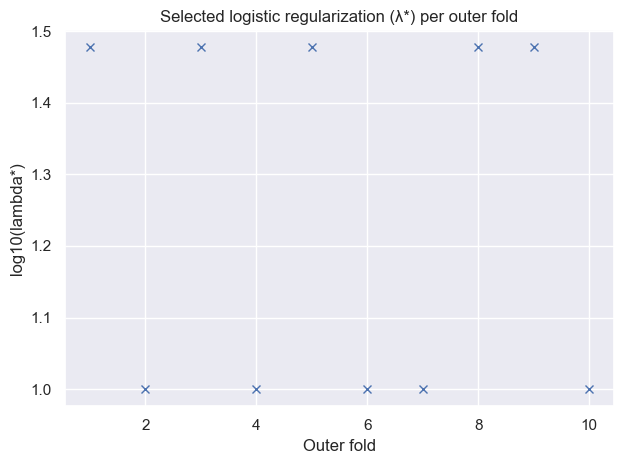

In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Plots section
# EDITED: None - used as-is
# PURPOSE: Create visualization plots for error rates and selected hyperparameters

plots = Path("p2_figs"); plots.mkdir(exist_ok=True)

plt.figure()
plt.bar(["ANN (method 2)", "Logistic", "Baseline"],
        [res_df["method2_test_error"].mean(),
         res_df["logistic_test_error"].mean(),
         res_df["baseline_test_error"].mean()])
plt.ylabel("Mean error rate (outer CV)")
plt.title("Mean error rate by model")
plt.tight_layout(); plt.savefig(plots/"mean_error_rates.png", dpi=160); plt.show()

x = np.arange(1, len(res_df)+1)
plt.figure()
plt.plot(x, res_df["method2_test_error"].values, marker="o", linestyle="None", label="ANN")
plt.plot(x, res_df["logistic_test_error"].values, marker="x", linestyle="None", label="Logistic")
plt.plot(x, res_df["baseline_test_error"].values, marker="s", linestyle="None", label="Baseline")
plt.xlabel("Outer fold"); plt.ylabel("Error rate on outer test fold")
plt.title("Per-fold error rates (outer CV)")
plt.legend(); plt.tight_layout()
plt.savefig(plots/"per_fold_errors.png", dpi=160); plt.show()

plt.figure()
plt.plot(x, res_df["method2_param_x_star"].values, marker="o", linestyle="None")
plt.xlabel("Outer fold"); plt.ylabel("Best h (hidden units)")
plt.title("Selected ANN capacity (h*) per outer fold")
plt.tight_layout(); plt.savefig(plots/"selected_h_per_fold.png", dpi=160); plt.show()

plt.figure()
plt.plot(x, np.log10(res_df["logistic_lambda_star"].values), marker="x", linestyle="None")
plt.xlabel("Outer fold"); plt.ylabel("log10(lambda*)")
plt.title("Selected logistic regularization (λ*) per outer fold")
plt.tight_layout(); plt.savefig(plots/"selected_lambda_per_fold.png", dpi=160); plt.show()


# Final logistic on full data + coefficients


,feature,coef,abs_coef
9,age,0.4833,0.4833
5,famhist,0.3780,0.3780
2,tobacco,0.3155,0.3155
3,ldl,0.2863,0.2863
6,typea,0.2582,0.2582
7,obesity,-0.1589,0.1589
1,sbp,0.1443,0.1443
4,adiposity,0.1352,0.1352
0,row.names,-0.1009,0.1009
8,alcohol,0.0150,0.0150


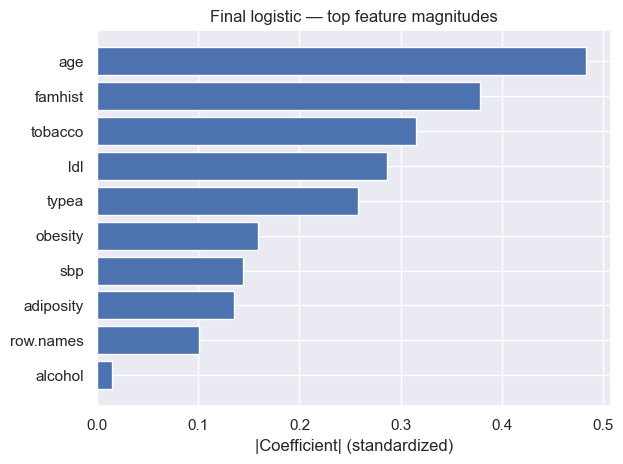

Chosen final λ (median of outer λ*): 20  (C = 0.05)
Logistic predicts 1 if σ(w^T x + b) ≥ 0.5 (or your chosen threshold).


In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Final logistic model section
# EDITED: None - used as-is
# PURPOSE: Train final logistic regression model on full dataset using median λ* from CV, and display coefficients

lambda_star_final = float(np.median(res_df["logistic_lambda_star"].values))
C_final = 1.0 / lambda_star_final

final_logreg = Pipeline([("prep", preprocess),
                         ("clf", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000, C=C_final))]).fit(X, y)

_ = final_logreg.named_steps["prep"].fit_transform(X)

def get_feature_names(preprocessor, numeric_cols, categorical_cols):
    names = list(numeric_cols)
    if categorical_cols:
        ohe = preprocessor.named_transformers_["cat"]["ohe"]
        names += ohe.get_feature_names_out(categorical_cols).tolist()
    return names

feat_names = get_feature_names(final_logreg.named_steps["prep"], num_cols, cat_cols)
coefs = final_logreg.named_steps["clf"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)
display(coef_df_sorted.head(15))

plt.figure()
top = coef_df_sorted.head(12)
plt.barh(top["feature"].values[::-1], top["abs_coef"].values[::-1])
plt.xlabel("|Coefficient| (standardized)")
plt.title("Final logistic — top feature magnitudes")
plt.tight_layout(); plt.savefig(plots/"final_logistic_top_coefs.png", dpi=160); plt.show()

print(f"Chosen final λ (median of outer λ*): {lambda_star_final:.6g}  (C = {C_final:.6g})")
print("Logistic predicts 1 if σ(w^T x + b) ≥ 0.5 (or your chosen threshold).")


# Optional: Save CSVs for your report


In [ ]:
# SOURCE: Project2_Classification_SAHeart.ipynb (Cell 1) - Save CSVs section
# EDITED: None - used as-is
# PURPOSE: Save all results to CSV files for report generation

out_dir = Path("p2_outputs"); out_dir.mkdir(exist_ok=True)
res_df.to_csv(out_dir/"nestedCV_table.csv", index=False)
summary.to_csv(out_dir/"summary.csv", index=False)
mcnemar_df.to_csv(out_dir/"mcnemar.csv", index=False)
pt_df.to_csv(out_dir/"paired_t.csv", index=False)

print("Saved outputs to", out_dir.resolve())
